In [1]:
%pylab inline
import pandas as pd

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


/Users/vale/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
s_sample_info = pd.read_csv('segerstolpe_sample_info.csv', index_col=0)

In [5]:
s_expr = pd.read_csv('segerstolpe_exprs.csv', index_col=0)

In [291]:
s_expr['gene'] = s_expr.index

In [294]:
s_long = s_expr.melt(id_vars=['gene'], var_name='cell', value_name='log2cpm')

In [295]:
s_long.to_csv('long_exprs.csv')

In [315]:
s_long_s = s_long.replace(0., np.nan).dropna()

In [316]:
s_long_s.to_csv('segerstolpe_long_exprs.csv', index=False)

In [318]:
s_sample_info.index.name = 'cell'

In [320]:
s_sample_info.to_csv('segerstolpe_sample_info2.csv')

In [244]:
from sklearn.model_selection import train_test_split

In [247]:
X_train, X_test, y_train, y_test = train_test_split(s_expr.T, s_sample_info['cell_type1'], test_size=.2)

In [249]:
from sklearn.linear_model import LogisticRegression

In [250]:
lr = LogisticRegression(C=0.05, penalty='l1', n_jobs=-1)

In [251]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [252]:
lr.classes_

array(['MHC class II', 'PSC', 'acinar', 'alpha', 'beta', 'co-expression',
       'delta', 'ductal', 'endothelial', 'epsilon', 'gamma', 'mast',
       'not applicable', 'unclassified', 'unclassified endocrine'], dtype=object)

In [253]:
lr.coef_.shape

(15, 25525)

In [255]:
y_hat = lr.predict(X_train)

In [256]:
y_hat

array(['alpha', 'acinar', 'beta', ..., 'not applicable', 'not applicable',
       'alpha'], dtype=object)

In [257]:
from sklearn import metrics

In [258]:
print(metrics.confusion_matrix(y_train, y_hat))

[[   4    0    0    0    0    0    0    0    0    0    0    0    1    0
     0]
 [   0   43    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0  143    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0  711    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0  216    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    1    3   24    1    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0   86    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0  307    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0   12    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    6    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0  157    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    5    0    0
     0]
 [   0    1    4    9    3    0    1    

In [259]:
lr.score(X_train, y_train)

0.98078975453575246

In [264]:
sparsity = np.mean(lr.coef_.ravel() == 0) * 100
sparsity

99.611361410381988

In [265]:
for i in s_expr.index[np.any(lr.coef_ > 0., 0)]:
    print(i, end=', ')

PRUNE, SFPQ, RAB3B, LEPR, SMG5, MTR, RGS7, LINC01128, SZT2, CMPK1, RAVER2, LPHN2, IGSF3, NOTCH2NL, SEC22B, BCL9, CTSS, POGZ, IL6R, ELF3, SUSD4, GNG4, SAMD11, VWA1, TPRG1L, ENO1, TMEM51, ZBTB17, SZRD1, RSRP1, WDTC1, LAPTM5, TINAGL1, MEAF6, CAP1, ZMPSTE24, PPIH, TSPAN1, PDZK1IP1, TACSTD2, HHLA3, FUBP1, RPL5, S1PR1, SARS, CEPT1, LOC643355, MOV10, BCAS2, CD58, RBM8A, ANP32E, CTSK, S100A10, S100A6, S100A14, FLAD1, SCAMP3, MRPL24, RGS4, GAS5, LAMC2, IVNS1ABP, RGS2, RNPEP, C1orf116, PFKFB2, CD55, CD46, HSD11B1, BROX, RNF187, AGT, GNPAT, NTPCR, ERO1LB, ASAP2, LCLAT1, EML4, SPTBN1, AAK1, TTC31, FHL2, TMEM37, ITGB6, PSMD14, FAP, DPP4, CHN1, GLS, GTF3C3, CYP27A1, FARSB, WDFY1, ODC1, SDC1, KCNK3, GTF3C2, KRTCAP3, SLC4A1AP, SLC3A1, MTHFD2, REG1B, TMSB10, GGCX, MRPS5, LINC00342, NEURL3, FBLN7, PSD4, STEAP3, NMI, TNFAIP6, GCG, GALNT3, G6PC2, ATP5G3, COL3A1, SLC40A1, ASNSD1, IGFBP5, FEV, CRYBA2, SCG2, SEPT2, ATG7, FNDC3B, MECOM, KCNMB2, OSBPL10, OXSR1, DCP1A, SENP7, KPNA1, ITGB5, MRPL3, AMOTL2, PFN2, 

In [267]:
shift_idx = y_train.argsort()

In [268]:
sorted_idx = y_train.sort_values().index

In [270]:
y_prob = lr.predict_log_proba(X_train.loc[sorted_idx])

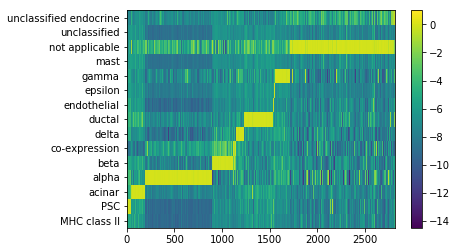

In [271]:
plt.pcolor(y_prob.T, vmax=1)
plt.yticks(0.5 + np.arange(lr.classes_.shape[0]), lr.classes_);
plt.colorbar();

In [272]:
sel_features = s_expr.index[np.any(lr.coef_ > 0., 0)]
sel_features.shape

(672,)

In [273]:
lr_softmax = LogisticRegression(C=0.05, penalty='l2', n_jobs=-1, multi_class='multinomial',
                                solver='sag', max_iter=1000)

In [275]:
lr_softmax.fit(X_train[sel_features], y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [276]:
lr_softmax.score(X_train[sel_features], y_train)

1.0

In [277]:
lr_softmax.score(X_test[sel_features], y_test)

0.92745376955903269

In [284]:
X_random = np.random.randn(100000, sel_features.shape[0])

In [286]:
lr_softmax.predict(X_random)

array(['not applicable', 'unclassified endocrine', 'not applicable', ...,
       'co-expression', 'alpha', 'delta'], dtype=object)

In [166]:
lr_softmax

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [169]:
y_prob = lr_softmax.predict_log_proba(X[sel_features].loc[sorted_idx])

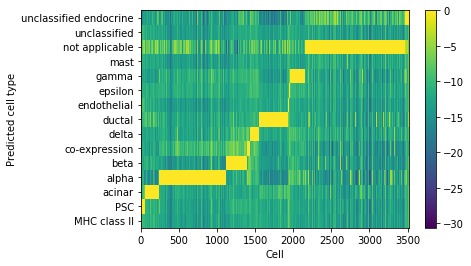

In [203]:
plt.pcolor(y_prob.T, vmax=0)
plt.yticks(0.5 + np.arange(lr_softmax.classes_.shape[0]), lr_softmax.classes_);
plt.colorbar();
plt.ylabel('Predicted cell type')
plt.xlabel('Cell');

In [188]:
y_hat = lr_softmax.predict(X[sel_features])

In [189]:
print(metrics.confusion_matrix(y, y_hat))

[[   5    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0   54    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0  185    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0  886    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0  270    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0   39    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0  114    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0  386    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0   16    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    7    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0  197    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    7    0    0
     0]
 [   0    0    0    0    0    0    0    

In [197]:
marker_genes = pd.DataFrame(
{'cell_type': lr_softmax.classes_[np.abs(lr_softmax.coef_).argmax(0)],
 'gene': sel_features})

In [202]:
marker_genes.groupby('cell_type').head(4).sort_values('cell_type')

,cell_type,gene
708,MHC class II,HCK
532,MHC class II,GPR183
509,MHC class II,LYZ
246,MHC class II,HLA-DRA
58,PSC,CTSK
77,PSC,HSD11B1
120,PSC,TNFAIP6
126,PSC,COL3A1
178,acinar,GPR160
175,acinar,CPB1


In [205]:
m_sample_info = pd.read_csv('muraro_sample_info.csv', index_col=0)
m_expr = pd.read_csv('muraro_exprs.csv', index_col=0)

In [209]:
m_expr.index = m_expr.index.str.split('_').str.get(0)

In [297]:
m_expr['gene'] = m_expr.index

In [298]:
m_long = m_expr.melt(id_vars=['gene'], var_name='cell', value_name='log2cpm')

In [299]:
m_long.shape

(40664002, 3)

In [303]:
m_long_s = m_long.replace(0., np.nan).dropna()

In [305]:
!ls

Linear model.ipynb
long_exprs.csv
muraro.rds
muraro_exprs.csv
muraro_sample_info.csv
reading data.Rmd
scRNA-seq supervised classification.Rproj
segerstolpe.rds
segerstolpe_exprs.csv
segerstolpe_sample_info.csv


In [307]:
m_long_s.to_csv('long_muraro_exprs.csv', index=False)

In [311]:
m_sample_info.index.name = 'cell'

In [312]:
m_sample_info.to_csv('muraro_sample_info2.csv')

In [219]:
X_new = m_expr.loc[sel_features].T.fillna(0)

In [222]:
m_sample_info['pred_cell_type'] = lr_softmax.predict(X_new)

In [223]:
m_sample_info[['cell_type1', 'pred_cell_type']]

,cell_type1,pred_cell_type
D28.1_1,alpha,alpha
D28.1_13,ductal,ductal
D28.1_15,alpha,alpha
D28.1_17,alpha,alpha
D28.1_2,endothelial,endothelial
D28.1_26,endothelial,not applicable
D28.1_29,alpha,alpha
D28.1_3,delta,delta
D28.1_30,alpha,alpha
D28.1_37,acinar,acinar


In [225]:
print(metrics.confusion_matrix(m_sample_info['cell_type1'], m_sample_info['pred_cell_type']))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 212   0   0   0   0   0   0   0   0   0   0   6   1   0]
 [  0   0   1 595   0  18   0   5   0   0   1   0   0 192   0   0]
 [  0   1   2   2 359  17   2   3   0   0   5   0   0  42  15   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   2 175   0   0   0   0   0   0  12   2   0]
 [  2   3   7   0   0   0   0 208   0   0   1   1   0  22   1   0]
 [  0   1   0   0   0   0   0   0  11   0   0   0   0   9   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0  80   0   0  19   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  77   0   0   0   0   0   1   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [243]:
m_sample_info \
    .groupby(['cell_type1', 'pred_cell_type']) \
    .count().iloc[:, [0]] \
    .unstack().T \
    .fillna(0)

cell_type1                    acinar  alpha   beta  delta  ductal  \
      pred_cell_type                                                
donor MHC class II               0.0    0.0    0.0    0.0     2.0   
      PSC                        0.0    0.0    1.0    0.0     3.0   
      acinar                   212.0    1.0    2.0    0.0     7.0   
      alpha                      0.0  595.0    2.0    0.0     0.0   
      beta                       0.0    0.0  359.0    2.0     0.0   
      co-expression              0.0   18.0   17.0    2.0     0.0   
      delta                      0.0    0.0    2.0  175.0     0.0   
      ductal                     0.0    5.0    3.0    0.0   208.0   
      endothelial                0.0    0.0    0.0    0.0     0.0   
      epsilon                    0.0    0.0    0.0    0.0     0.0   
      gamma                      0.0    1.0    5.0    0.0     1.0   
      mast                       0.0    0.0    0.0    0.0     1.0   
      not applicable             6.0  192.0   42.0   12.0    22.0   
      unclassified endocrine     1.0    0.0   15.0    2.0     1.0   

cell_type1                    endothelial  epsilon  gamma  mesenchymal  \
      pred_cell_type                                                     
donor MHC class II                    0.0      0.0    0.0          0.0   
      PSC                             1.0      0.0    0.0         77.0   
      acinar                          0.0      0.0    2.0          0.0   
      alpha                           0.0      0.0    0.0          0.0   
      beta                            0.0      0.0    0.0          0.0   
      co-expression                   0.0      0.0    0.0          0.0   
      delta                           0.0      0.0    0.0          0.0   
      ductal                          0.0      0.0    0.0          1.0   
      endothelial                    11.0      0.0    0.0          0.0   
      epsilon                         0.0      3.0    0.0          0.0   
      gamma                           0.0      0.0   80.0          0.0   
      mast                            0.0      0.0    0.0          0.0   
      not applicable                  9.0      0.0   19.0          2.0   
      unclassified endocrine          0.0      0.0    0.0          0.0   

cell_type1                    unclear  
      pred_cell_type                   
donor MHC class II                0.0  
      PSC                         0.0  
      acinar                      0.0  
      alpha                       0.0  
      beta                        0.0  
      co-expression               0.0  
      delta                       0.0  
      ductal                      3.0  
      endothelial                 0.0  
      epsilon                     0.0  
      gamma                       0.0  
      mast                        0.0  
      not applicable              1.0  
      unclassified endocrine      0.0